<h1>Computer Vision and Image Processing</h1>
<h2>Fruit Inspection - First Task</h2>
<h4>Alex Gianelli<br/>Andrea Castronovo</h4>

In this document we will develop an Image Processing routine in order to solve the First Task of a University Computer Vision project (<a href="./fruit-inspection.pdf">file</a>).

The target images are the following:
<ul>
    <li><a href="./first task/C1_000001.png">Image 01</a></li>
    <li><a href="./first task/C1_000002.png">Image 02</a></li>
    <li><a href="./first task/C1_000003.png">Image 03</a></li>
</ul>

<b>NIR</b> versions of the same images are also provided:
<ul>
    <li><a href="./first task/C0_000001.png">NIR Image 01</a></li>
    <li><a href="./first task/C0_000002.png">NIR Image 02</a></li>
    <li><a href="./first task/C0_000003.png">NIR Image 03</a></li>
</ul>
<br/>

The objectives of this task are:
<ul>
    <li>Outline the fruit by generating a <b>binary mask</b>.</li>
    <li>Search for the <b>defects</b> on each fruit.</li>
</ul>

We advise to <b><i>Run All</i></b> the scripts before reading the document, for a better understanding of the report.
<br/><br/>
The code begins by importing all the necessary libraries/packages.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

<b>Choose the target image <i>HERE</i></b>.

In [23]:
# Chose the image HERE (1-3)
IMG = 2

We import both the colored image and the NIR. In this task we will focus on the NIR and we will show the result on the colored image.

<b>Important note</b>: the image couples are not aligned, we considered alignment but we decided it was not useful for this task.

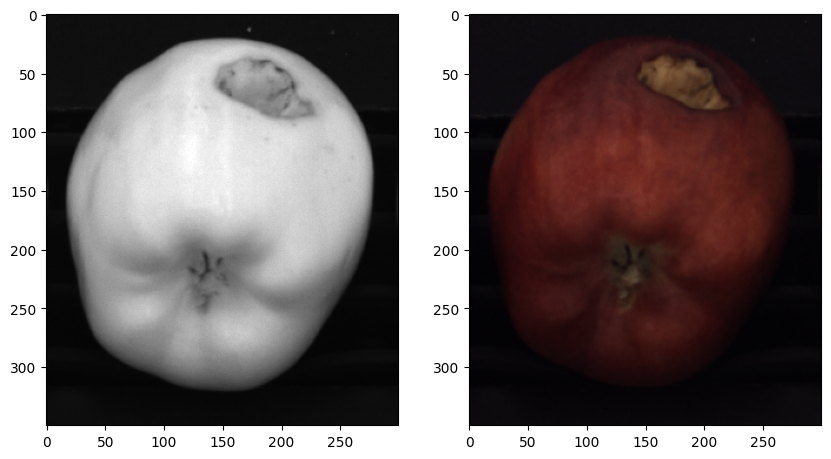

In [24]:
img = cv2.imread('first task/C0_00000' + str(IMG) + ".png", cv2.IMREAD_GRAYSCALE)
img_c = cv2.imread('first task/C1_00000' + str(IMG) + ".png")

img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2, figsize = (10,10))
axarr[0].imshow(img,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(img_c,vmin=0, vmax=255)
plt.show()

<h3>Generating a Binary Mask</h3>

Firstly, we apply a <b>Gaussian Blur</b> filter on the image and then a simple <b>threshold</b> on it, ending up with an already clear binary mask.</br>
We considered using OTSU and other Adaptive Thresholding methods but we found that for our pool of images this simple approach was already showing perfect results, so we decided to stick with simplicity.

With this mask we can already clear the background.

<i>The function parameters were determined empirically.</i>

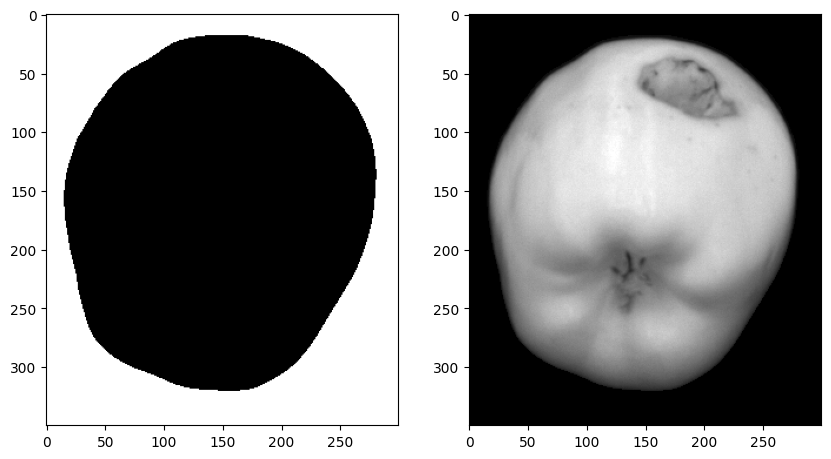

In [25]:
sigma = 2.5
k_size = int(np.ceil((3*sigma))*2 + 1)

img_gf = cv2.GaussianBlur(img, (k_size,k_size), sigma)

threshold = 30

_, mask = cv2.threshold(img_gf, threshold, 255, cv2.THRESH_BINARY_INV)

background = np.zeros_like(img)

bg_clean = np.where(mask==np.array([0]), img, background)

f, axarr = plt.subplots(1,2,figsize = (10,10))
axarr[0].imshow(mask,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(bg_clean,cmap='gray',vmin=0, vmax=255)
plt.show()

<h3>Search of the Defects</h3>

We will now begin the isolation of the <b>defects</b> inside the fruit border.

In this NIR images the defects have a very clear contrast between the healthy surface. We can use an edge detection algorithm like <b>Canny</b> to find them.

We tried adding a small Gaussian Blur before Canny to avoid some unwanted edges, but we ended up not using it due to the fact that we will use a filter to discard unwanted edges later in any case.

<i>The function parameters were determined empirically.</i>

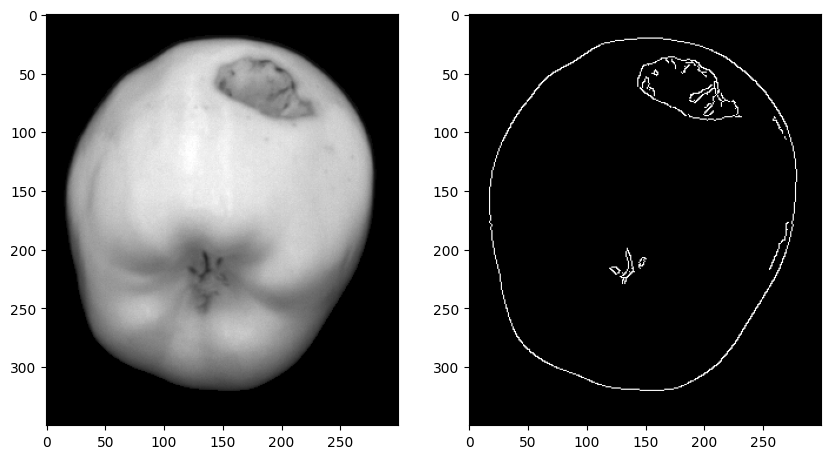

In [26]:
edge = cv2.Canny(bg_clean, 50, 130)

f, axarr = plt.subplots(1,2,figsize = (10,10))
axarr[0].imshow(bg_clean,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(edge,cmap='gray',vmin=0, vmax=255)
plt.show()

Now that we found our edges we can eliminate the external fruit edge by simply taking the contour with the highest area and subtracting it to the edge image.

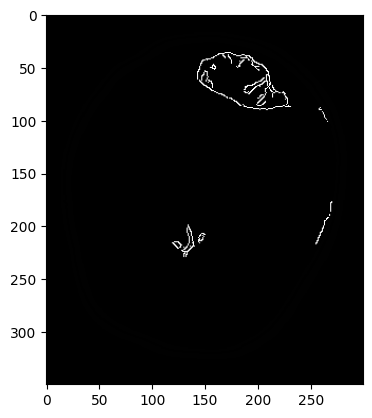

In [27]:
contours = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

background = np.zeros_like(img)

cv2.drawContours(background, [big_contour], -1, (255), 1)

rect = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
dilatedbg = cv2.dilate(background,rect,iterations = 3)

sub = edge - dilatedbg

plt.imshow(sub, cmap='gray', vmin=0, vmax=255)
plt.show()

After a small dilate operator to make the edges a bit more consistent, we can now filter the contours that we don't deem to be belonging to defects. To do this, a few observations and assumptions have been made:
<ul>
    <li>All the photos have been taken at a <b>constant distance</b> from the fruit.</li>
    <li>We assume that defects need to have a <b>minimum area dimension</b> in order to be consider as such.</li>
</ul>

We have than used the following criteria in the filtering process:
<ul>
    <li>The contours with an area under a given thresold will not be considered.</li>   
    <li>The contours that contain a lot of white pixels will be deleted, this will help us filer narrow lines like stems or near-border lines.</li>
</ul>

This filters do overlap in some cases but we consider more possibilities this way.

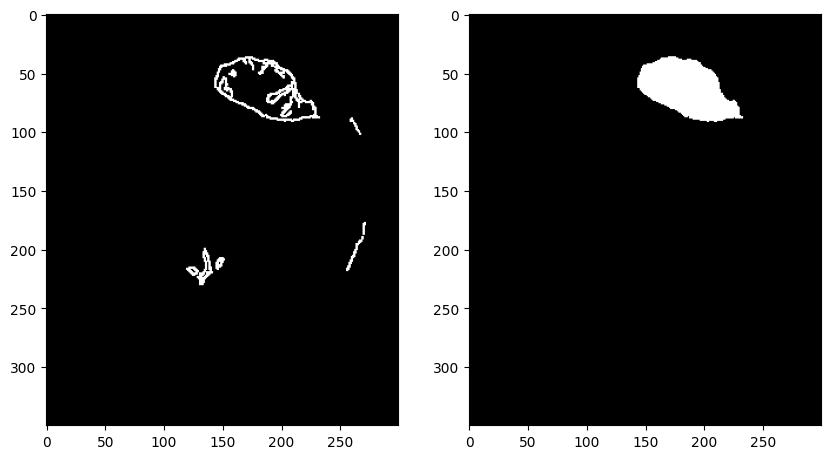

In [28]:
sub[sub<255] = 0

rect = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
sub_dil = cv2.dilate(sub, rect, 1)

contours, _ = cv2.findContours(sub_dil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)

defects = np.zeros_like(img)

for c in contours:
    blank = np.zeros(img.shape, dtype = 'uint8')
    cv2.drawContours(blank, [c], -1,(255,255,255),-1)

    pps = np.where(blank == 255)
    pixels = sub[pps]

    if (cv2.contourArea(c) > 45 and np.mean(pixels) < 100):
        cv2.drawContours(defects, [c], -1, (255), thickness = cv2.FILLED)

f, axarr = plt.subplots(1,2,figsize = (10,10))
axarr[0].imshow(sub_dil, cmap = 'gray', vmin = 0, vmax = 255)
axarr[1].imshow(defects, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()


We are now able to mark the defects on the colored image using the mask we created.

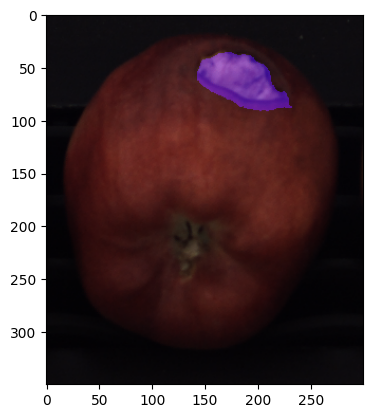

In [29]:
color_defects = np.zeros_like(img_c)

color_defects[defects == 255] = [40, 0, 160]

highImg = cv2.addWeighted(img_c, 1, color_defects, 0.8, 0)

plt.imshow(highImg)
plt.show()